In [1]:
!pip install transformers

In [2]:
!pip install datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: levenshtein
    Found existing installation: Levenshtein 0.20.7
    Uninstalling Levenshtein-0.20.7:
      Successfully uninstalled Levenshtein-0.20.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-levenshtein 0.20.7 requires Levenshtein==0.20.7, but you have levenshtein 0.20.2 which is incompatible.


In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ["WANDB_DISABLED"] = "true"

In [4]:
with open('../input/devanagiri-dataset/hindi_vocab.txt') as f:
    vocab = f.readlines()
print(vocab[100])

उज्ज्वल



In [5]:
len(vocab)

11030

In [6]:
with open('../input/devanagiri-dataset/train.txt') as f:
    train = f.readlines()

counter = 0

train_list = []
for i in range(len(train)):
    if counter > 5000:
        break
    image_id = train[i].split("\n")[0].split(' ')[0].strip()
#     vocab_id = int(train[i].split(",")[1].strip())
    text = train[i].split("\n")[0].split(' ')[1].strip()
    row = [image_id, text]
    train_list.append(row)
    counter += 1

train_df = pd.DataFrame(train_list, columns=['file_name', 'text'])
train_df.head()

,file_name,text
0,HindiSeg/train/8/251/21.jpg,केंद्रों
1,HindiSeg/train/10/207/8.jpg,पॉवर
2,HindiSeg/train/10/31/19.jpg,तरक्की
3,HindiSeg/train/5/246/23.jpg,मजा
4,HindiSeg/train/8/266/25.jpg,मांजने


In [7]:
with open('../input/devanagiri-dataset/test.txt') as f:
    test = f.readlines()

counter = 0
test_list = []
for i in range(len(test)):
    if counter > 2000:
        break
    image_id = test[i].split("\n")[0].split(' ')[0].strip()
#     vocab_id = int(train[i].split(",")[1].strip())
    text = test[i].split("\n")[0].split(' ')[1].strip()
    row = [image_id, text]
    test_list.append(row)
    counter += 1

test_df = pd.DataFrame(test_list, columns=['file_name', 'text'])
test_df.head()


,file_name,text
0,HindiSeg/test/9/2/22.jpg,अनाथों
1,HindiSeg/test/11/2/24.jpg,इज्ज्त
2,HindiSeg/test/11/55/29.jpg,देखना
3,HindiSeg/test/11/23/7.jpg,मृतका
4,HindiSeg/test/6/59/9.jpg,ऊर्ध्वगामी


In [8]:
with open('../input/devanagiri-dataset/val.txt') as f:
    val = f.readlines()
counter = 0
val_list = []
for i in range(len(val)):
    if counter > 2000:
        break
    image_id = val[i].split("\n")[0].split(' ')[0].strip()
#     vocab_id = int(train[i].split(",")[1].strip())
    text = val[i].split("\n")[0].split(' ')[1].strip()
    row = [image_id, text]
    val_list.append(row)
    counter += 1
    
val_df = pd.DataFrame(val_list, columns=['file_name', 'text'])
val_df.head()


,file_name,text
0,HindiSeg/val/3/165/18.jpg,शरावती
1,HindiSeg/val/12/43/27.jpg,जोख
2,HindiSeg/val/12/1/36.jpg,बहादुर
3,HindiSeg/val/3/142/25.jpg,बकवास
4,HindiSeg/val/3/169/39.jpg,मॉ


In [9]:
print(train_df.shape, test_df.shape, val_df.shape)

(5001, 2) (2001, 2) (2001, 2)


In [10]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
#         print(encoding)
        return encoding

In [11]:
from transformers import ViTFeatureExtractor, RobertaTokenizer, TrOCRProcessor, PreTrainedTokenizerFast
from transformers import VisionEncoderDecoderModel
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelForMaskedLM

encode = 'google/vit-base-patch16-224-in21k'
decode = 'flax-community/roberta-hindi'

feature_extractor=ViTFeatureExtractor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

from transformers import TrOCRProcessor

train_dataset = IAMDataset(root_dir='../input/devanagiri-dataset/HindiSeg/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='../input/devanagiri-dataset/HindiSeg/',
                           df=test_df,
                           processor=processor)

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
print(processor.tokenizer.pad_token_id)
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# config_decoder.is_decoder = True
# config_decoder.add_cross_attention = True

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/279 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/692 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at flax-community/roberta-hindi and are newly initialized: ['roberta.encoder.layer.5.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.10.crossattention.output.dense.weight', 'roberta.encoder.layer.7.crossattention.output.dense.weight', 'roberta.encoder.layer.5.crossattention.self.query.bias', 'roberta.encoder.layer.8.crossattention.self.query.weight', 'roberta.encoder.layer.7.crossattention.self.key.bias', 'roberta.encoder.layer.8.crossattention.self.value.bias', 'roberta.encoder.layer.9.crossattention.self.key.weight', 'roberta.encoder.layer.4.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.6.crossattention.self.key.weight', 'roberta.encoder.layer.4.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.10.crossattention.self.value.weight', 'roberta.encoder.layer.6.crossattention.self.query.weight', 'roberta.e

1


In [12]:
# !huggingface-cli

In [13]:
# from transformers import TrOCRProcessor

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# train_dataset = IAMDataset(root_dir='../input/indic-handwritten-text-malayalam/train/train/',
#                            df=train_df,
#                            processor=processor)
# eval_dataset = IAMDataset(root_dir='../input/indic-handwritten-text-malayalam/test/test/',
#                            df=test_df,
#                            processor=processor)

In [14]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 5001
Number of validation examples: 2001


In [15]:
print(type(train_dataset[0]))

<class 'dict'>


In [16]:
type(train_dataset)
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([128])


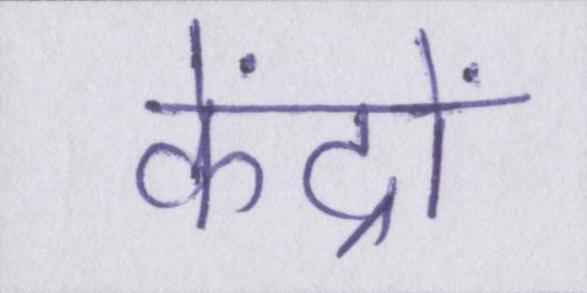

In [17]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [18]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

केंद्रों


In [19]:
# from transformers import VisionEncoderDecoderModel

# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

In [20]:
# # set special tokens used for creating the decoder_input_ids from the labels
# model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
# model.config.pad_token_id = processor.tokenizer.pad_token_id
# # make sure vocab size is set correctly
# model.config.vocab_size = model.config.decoder.vocab_size

# # set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
# model.config.max_length = 64
# model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
# model.config.num_beams = 4

In [21]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="./",
    logging_steps=2,
    save_steps=200,
    eval_steps=100,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [22]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [23]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [24]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5001
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 939
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Cer
100,3.403100,3.294471,0.900168
200,2.578700,2.646552,0.965017
300,2.385900,2.445118,1.117030
400,2.394000,2.312932,1.014346
500,2.271100,2.223647,0.851091
600,1.985600,2.127210,0.959060
700,1.968100,2.076150,1.009732
800,1.979900,2.010396,0.931544
900,1.994300,2.001764,0.959648


***** Running Evaluation *****
  Num examples = 2001
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2001
  Batch size = 16
Saving model checkpoint to ./checkpoint-200
Configuration saved in ./checkpoint-200/config.json
Model weights saved in ./checkpoint-200/pytorch_model.bin
Feature extractor saved in ./checkpoint-200/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 2001
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2001
  Batch size = 16
Saving model checkpoint to ./checkpoint-400
Configuration saved in ./checkpoint-400/config.json
Model weights saved in ./checkpoint-400/pytorch_model.bin
Feature extractor saved in ./checkpoint-400/preprocessor_config.js

TrainOutput(global_step=939, training_loss=2.483793988776283, metrics={'train_runtime': 2619.8055, 'train_samples_per_second': 5.727, 'train_steps_per_second': 0.358, 'total_flos': 2.7162043310570435e+18, 'train_loss': 2.483793988776283, 'epoch': 3.0})

In [27]:
ls

__notebook_source__.ipynb  checkpoint-400/  checkpoint-800/
checkpoint-200/            checkpoint-600/  runs/


In [28]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/checkpoint-800")

loading configuration file /kaggle/working/checkpoint-800/config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "flax-community/roberta-hindi",
    "add_cross_attention": true,
    "architectures": [
      "RobertaForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0": "LAB

कैलान


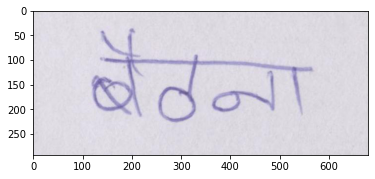

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open("/kaggle/input/devanagiri-dataset/HindiSeg/HindiSeg/test/11/1/1.jpg").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
plt.imshow(image)
print(generated_text)

प्रच्रार्य


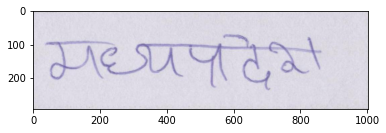

In [30]:
image = Image.open("/kaggle/input/devanagiri-dataset/HindiSeg/HindiSeg/test/11/1/10.jpg").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
plt.imshow(image)
print(generated_text)

प्राओं


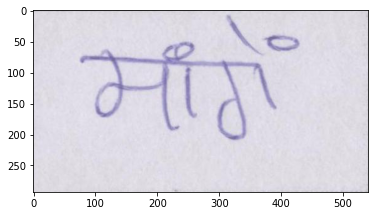

In [31]:
image = Image.open("/kaggle/input/devanagiri-dataset/HindiSeg/HindiSeg/test/11/1/29.jpg").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
plt.imshow(image)
print(generated_text)

मान्ता


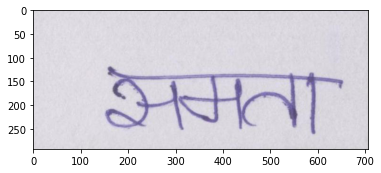

In [37]:
image = Image.open("/kaggle/input/devanagiri-dataset/HindiSeg/HindiSeg/train/10/111/1.jpg").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
plt.imshow(image)
print(generated_text)

प्रभाजा


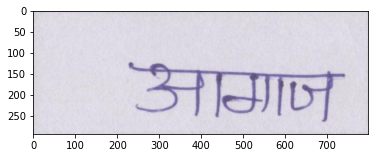

In [42]:
image = Image.open("/kaggle/input/devanagiri-dataset/HindiSeg/HindiSeg/train/10/250/10.jpg").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
plt.imshow(image)
print(generated_text)